# CMIP heat transport plots


# Setup

In [1]:
import os
import shutil
import glob
import pandas as pd
import numpy as np
import xarray as xr
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cmocean.cm as cmo

import warnings

In [2]:
## some magic to automatically reload my functions before running a new cell
%load_ext autoreload
## %reload_ext autoreload
%autoreload 1
%aimport my_functions

import my_functions as mf

## Figure settings

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160

# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

## Load dictionaries

In [4]:
# Get the last 40 years of the 1% CO2 runs and the corresponding time period in piControl
with open('../pkl_files/period_l40_slice_in_pi.pkl', 'rb') as file:
    period_l40_slice_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_pi.pkl', 'rb') as file:
    period_l40_start_year_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_pi.pkl', 'rb') as file:
    period_l40_end_year_in_pi = pkl.load(file)
with open('../pkl_files/start_year_in_pi.pkl', 'rb') as file:
    start_year_in_pi = pkl.load(file)
    
with open('../pkl_files/period_l40_slice_in_co2.pkl', 'rb') as file:
    period_l40_slice_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_co2.pkl', 'rb') as file:
    period_l40_start_year_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_co2.pkl', 'rb') as file:
    period_l40_end_year_in_co2 = pkl.load(file) 
with open('../pkl_files/start_year_in_co2.pkl', 'rb') as file:
    start_year_in_co2 = pkl.load(file)


# Get each model's variant_id
with open('../pkl_files/variant_id.pkl', 'rb') as file:
    variant_id = pkl.load(file)
    
# Get each model's table_id
with open('../pkl_files/table_id.pkl', 'rb') as file:
    table_id = pkl.load(file)
    
# Get each model's grid_label
with open('../pkl_files/grid_label.pkl', 'rb') as file:
    grid_label = pkl.load(file)
    
# Colors corresponding to each model
with open('../pkl_files/mcolors.pkl', 'rb') as file:
    mcolors = pkl.load(file)

In [5]:
mcolors = {'ACCESS-ESM1-5': '#2f4f4f',
           'BCC-CSM2-MR': '#8b4513',
           'CanESM5': '#6b8e23',
           'CESM2': '#4b0082',
           'CMCC-ESM2': '#ff0000',
           'CNRM-ESM2-1': '#ffff00',
           'EC-Earth3-CC': 'black',
           'GFDL-ESM4': '#40e0d0',
           'GISS-E2-1-G': '#00ff00',
           'IPSL-CM6A-LR': '#0000ff',
           'MIROC-ES2L': '#ff00ff',
           'MPI-ESM1-2-LR': '#6495ed',
           'NorESM2-LM': '#ff1493',
           'UKESM1-0-LL': '#ffc0cb'}

## Create constants

In [24]:
# Cases / experiments
cases = ['piControl', '1pctCO2', '1pctCO2-rad', '1pctCO2-bgc']
cases_rad = ['1pctCO2', '1pctCO2-rad']

# Models with data in /tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/ and CMIPmerge/
# --> removed MRI-ESM2-0 because 1pctCO2 and 1pctCO2-rad Amon variables are the same
# --> removed CanESM5 because server could not be reached and model output not available (yet?)

# --> models with HT, VEG for 1pctCO2 and 1pctCO2-rad (i.e., the max number of models used)
models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'EC-Earth3-CC', 'GFDL-ESM4', 'GISS-E2-1-G',
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM',
          'UKESM1-0-LL']
#  --> models with HT, VEG, SW for all cases
models_all = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CMCC-ESM2',
              'CNRM-ESM2-1', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'MIROC-ES2L',
              'MPI-ESM1-2-LR', 'UKESM1-0-LL']
# --> only models with HT, VEG, SW for 1pctCO2 and 1pctCO2-rad
models_radsw = ['EC-Earth3-CC']
# --> only models with HT, VEG for 1pctCO2 and 1pctCO2-rad
models_rad = ['CESM2', 'GFDL-ESM4', 'NorESM2-LM']

# Variables
variables = ['evspsbl', 'hfls', 'hfss', 'hus', 'lai', 'pr', 'prsn', 'ps',
             'rlds',  'rlus', 'rlut', 'rsds', 'rsdt', 'rsus', 'rsut', 'ta',
             'tas', 'uas', 'vas']
variables_ht = ['hfls', 'hfss', 'hus', 'pr', 'prsn', 'ps', 'rlds', 'rlus',
                'rlut', 'rsds', 'rsdt', 'rsus', 'rsut', 'ta']
variables_vegsw = ['evspsbl', 'lai', 'tas', 'uas', 'vas']
variables_veg = ['evspsbl', 'lai', 'tas']
variables_2d = ['evspsbl', 'hfls', 'hfss', 'lai', 'pr', 'prsn', 'ps',
                'rlds',  'rlus', 'rlut', 'rsds', 'rsdt', 'rsus', 'rsut',
                'tas', 'uas', 'vas']
variables_3d = ['hus', 'ta']
variables_nht = ['mht', 'oht', 'aht', 'ahtdry', 'ahtmoist']

# Months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_abbr = ['J','F','M','A','M','J','J','A','S','O','N','D']

# Directory where CMIP6 model output lives on tiger
cmipdir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/'
cmipmergedir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIPmerge/'
cmipgriddir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP1x1.25/'
cmipnhtdir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIPnht/'

# Get data

```CMIPnht/MPI-ESM1-2-LR/storagemoist_Amon_MPI-ESM1-2-LR_1pctCO2-rad_r1i1p1f1_zonal_195001-198912.nc```

In [25]:
def gettimeslice(m, c):
    if c == 'piControl':
        st = period_l40_start_year_in_pi[m].replace('-','')
        et = period_l40_end_year_in_pi[m].replace('-','')
        time = st+'-'+et
    elif c[:7] == '1pctCO2':
        st = period_l40_start_year_in_co2[m].replace('-','')
        et = period_l40_end_year_in_co2[m].replace('-','')
        time = st+'-'+et
    else:
        time = ''
    return time

In [26]:
def getnht(v, m, c):
    tslice = gettimeslice(m, c)
    path = cmipnhtdir+m+'/'+v+'_Amon_'+m+'_'+c+'_'+variant_id[m]+'_zonal_'+tslice+'.nc'
    return xr.open_dataset(path)[v]

In [21]:
ht = {}
for v in variables_nht:
    ht[v] = {}
    for m in models:
        ht[v][m] = {}
        for c in cases_rad:
            ht[v][m][c] = getnht(v, m, c)

/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itc

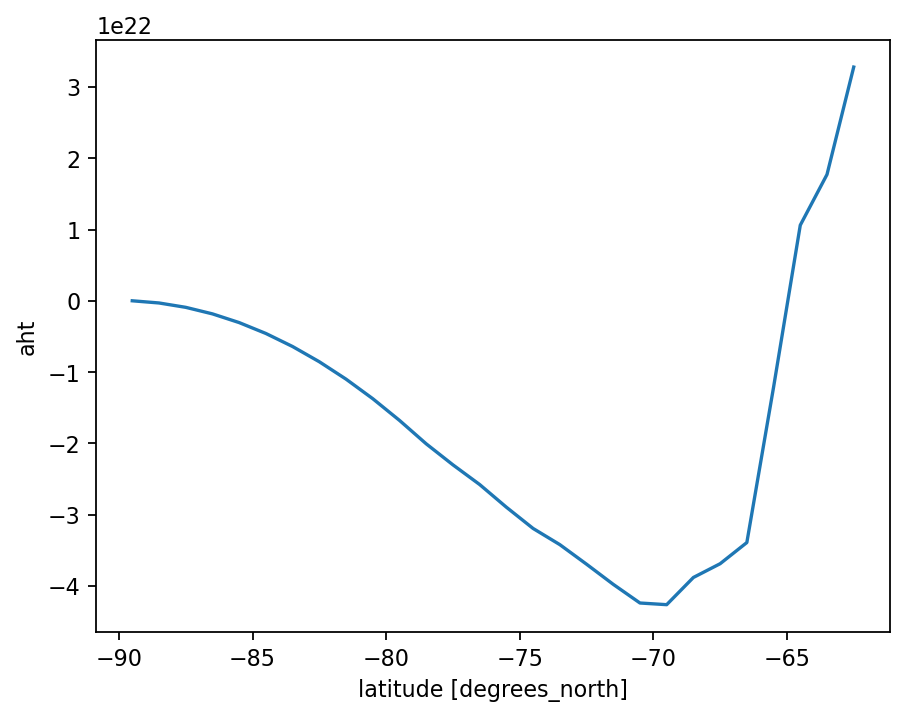

In [101]:
# ((ht['aht']['CESM2']['1pctCO2'] - ht['aht']['CESM2']['1pctCO2-rad']).mean(dim='time')/1e15).plot()
(ht['aht']['CESM2']['1pctCO2'].mean(dim='time')/1e15).plot()

Text(0.5, 0.98, 'CESM2')

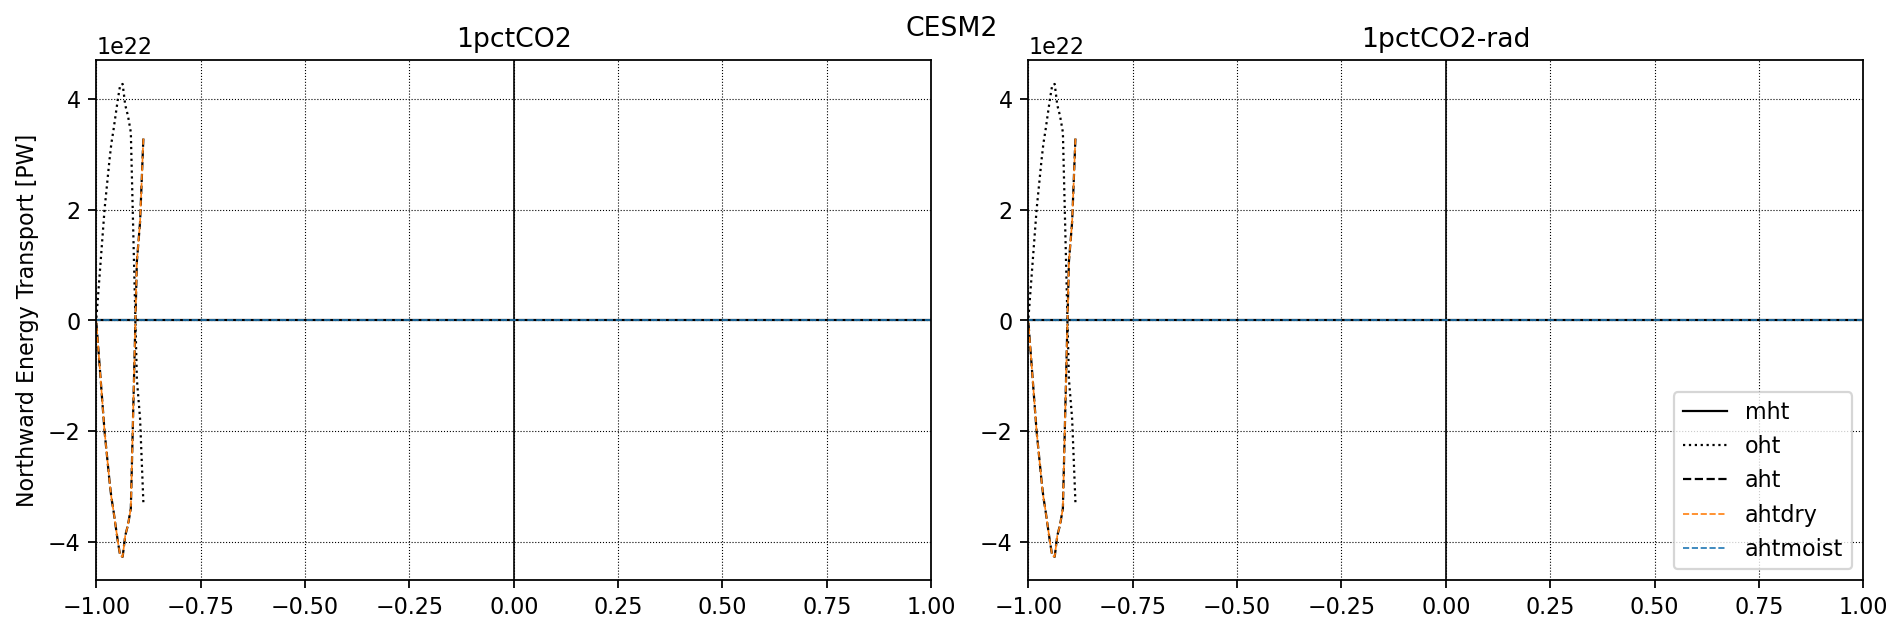

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax = ax.flatten()

m = 'CESM2'
latlim = 90

lat = ht['mht'][m]['1pctCO2'].lat.values
sinlat = np.sin(np.deg2rad(lat))
# xticks = np.sin(np.deg2rad([-80, -60, -40, -20, 0, 20, 40, 60, 80]))
# xticks = np.sin(np.deg2rad(np.arange(-latlim,latlim+1,(latlim-10)/4)))
# xticklabels = ['80S', '60S', '40S', '20S', 'EQ', '20N', '40N', '60N', '80N']

ls_dict = {'mht': '-', 'aht': '--', 'oht': ':', 'ahtmoist': '--', 'ahtdry': '--'}
c_dict = {'mht': 'k', 'aht': 'k', 'oht': 'k', 'ahtmoist': 'tab:blue', 'ahtdry': 'tab:orange'}
lw_dict = {'mht': '1', 'aht': '1', 'oht': '1', 'ahtmoist': '0.75', 'ahtdry': '0.75'}

for ic, c in enumerate(cases_rad):
    for v in variables_nht:
        ax[ic].plot(sinlat, ht[v][m][c].mean(dim='time')/1e15, label=v, ls=ls_dict[v], c=c_dict[v], lw=lw_dict[v])
    
    # ax[ic].set_ylim(-0.5, 0.5)
    ax[ic].set_xlim(-np.sin(np.deg2rad(latlim)), np.sin(np.deg2rad(latlim)))
    # ax[ic].set_xticks(xticks)
    # ax[ic].set_xticklabels(xticklabels)
    
    ax[ic].set_title(c)
    if ic%2 == 0:
        ax[ic].set_ylabel('Northward Energy Transport [PW]')
    if ic/2 >= 1:
        ax[ic].set_xlabel('Latitude')
            
    ax[ic].plot([-1,1], [0,0], c='k', lw=0.75, zorder=0)
    ax[ic].grid(c='k', ls=':', lw=0.5)

    low,high = ax[ic].get_ylim()
    ax[ic].set_ylim(low,high)
    ax[ic].plot([0,0], [low,high], c='k', lw=0.75, zorder=0)

ax[1].legend(loc='lower right')
fig.tight_layout()
fig.suptitle(m)

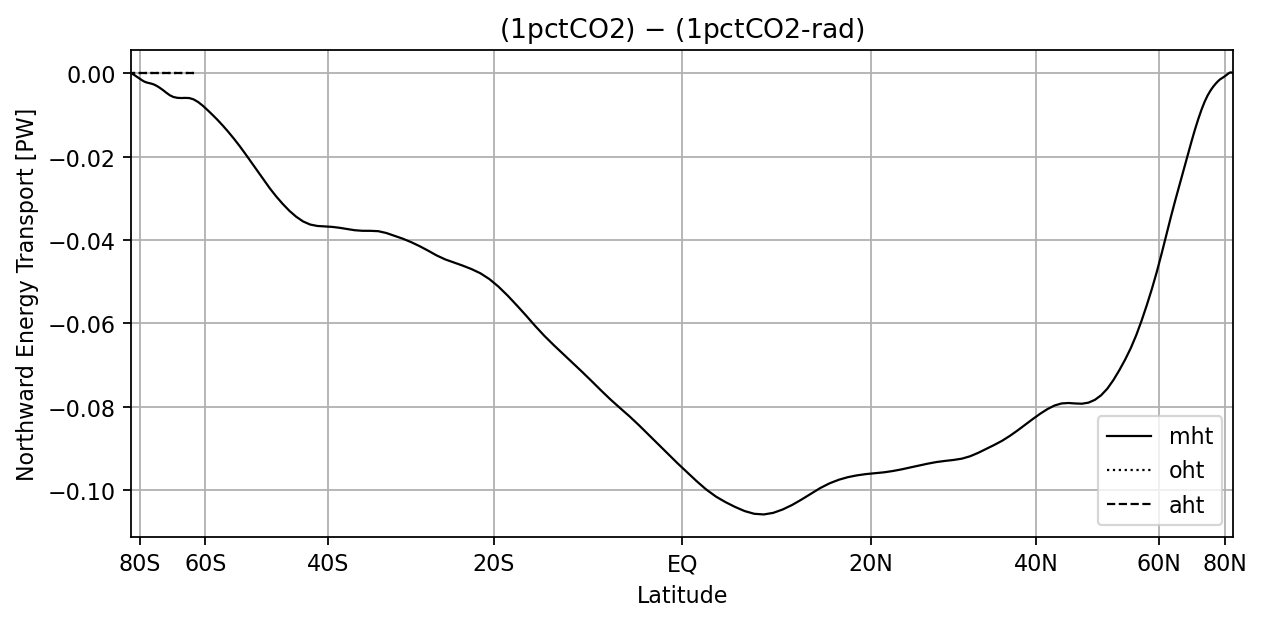

In [81]:
fig,ax = plt.subplots(figsize=(8,4))

m = 'CESM2'
v = 'mht'

lat = ht['mht'][m]['1pctCO2'].lat.values
sinlat = np.sin(np.deg2rad(lat))
xticks = np.sin(np.deg2rad([-80, -60, -40, -20, 0, 20, 40, 60, 80]))
xticklabels = ['80S', '60S', '40S', '20S', 'EQ', '20N', '40N', '60N', '80N']

ls_dict = {'mht': '-', 'aht': '--', 'oht': ':', 'ahtmoist': '--', 'ahtdry': '--'}
c_dict = {'mht': 'k', 'aht': 'k', 'oht': 'k', 'ahtmoist': 'tab:blue', 'ahtdry': 'tab:orange'}
lw_dict = {'mht': '1', 'aht': '1', 'oht': '1', 'ahtmoist': '0.75', 'ahtdry': '0.75'}

for v in variables_nht[:3]:
    ax.plot(sinlat, ht[v][m]['1pctCO2'].mean(dim='time')/1e15 - ht[v][m]['1pctCO2-rad'].mean(dim='time')/1e15, label=v, ls=ls_dict[v], c=c_dict[v], lw=lw_dict[v])

ax.set_xlim(-1, 1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.grid()
ax.set_ylabel('Northward Energy Transport [PW]')
ax.set_xlabel('Latitude')
ax.set_title('(1pctCO2) $-$ (1pctCO2-rad)')
ax.legend(loc='lower right')
fig.tight_layout()

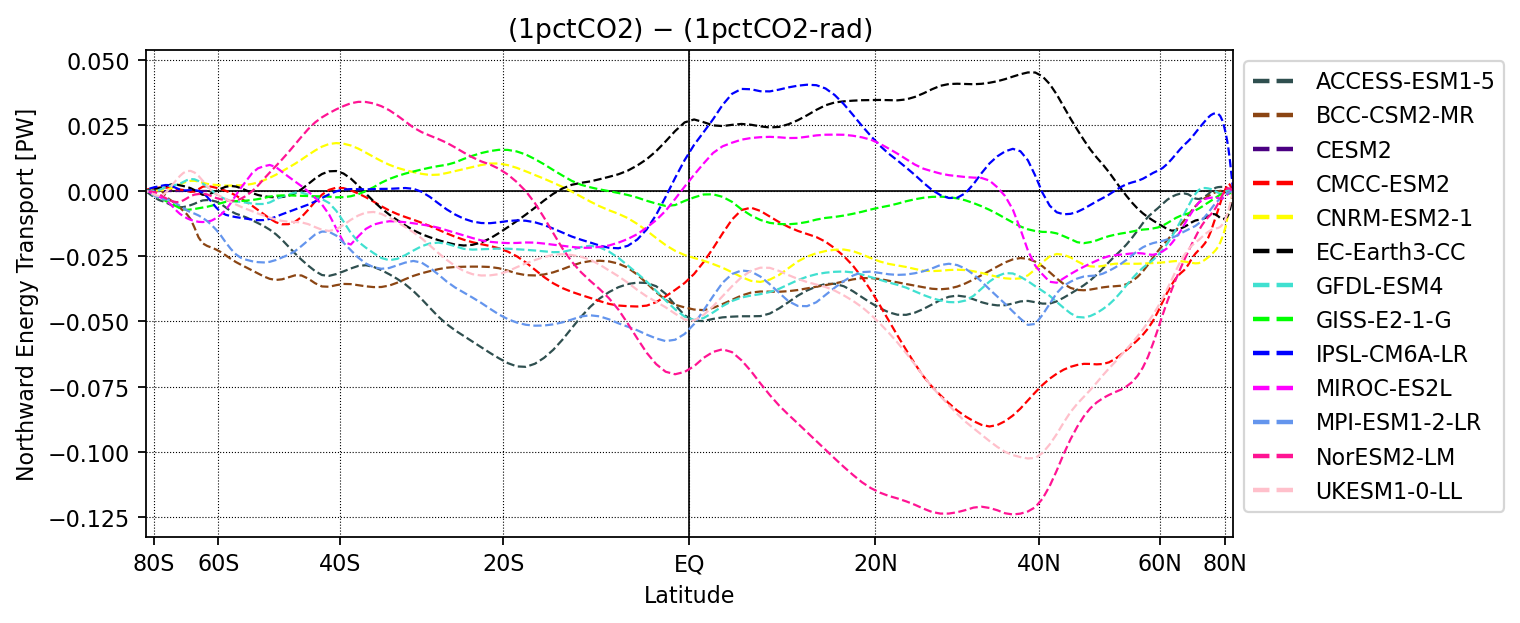

In [83]:
fig, ax = plt.subplots(figsize=(8,4))

m = 'ACCESS-ESM1-5'
v = 'aht'

lat = ht['mht'][m]['1pctCO2'].lat.values
sinlat = np.sin(np.deg2rad(lat))
xticks = np.sin(np.deg2rad([-80, -60, -40, -20, 0, 20, 40, 60, 80]))
xticklabels = ['80S', '60S', '40S', '20S', 'EQ', '20N', '40N', '60N', '80N']

ls_dict = {'mht': '-', 'aht': '--', 'oht': ':', 'ahtmoist': '--', 'ahtdry': '--'}
c_dict = {'mht': 'k', 'aht': 'k', 'oht': 'k', 'ahtmoist': 'tab:blue', 'ahtdry': 'tab:orange'}
lw_dict = {'mht': '1', 'aht': '1', 'oht': '1', 'ahtmoist': '0.75', 'ahtdry': '0.75'}

for m in models:
    ax.plot(sinlat, ht[v][m]['1pctCO2'].mean(dim='time')/1e15 - ht[v][m]['1pctCO2-rad'].mean(dim='time')/1e15, label=m, ls=ls_dict[v], c=mcolors[m], lw=lw_dict[v])

ax.set_xlim(-1, 1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel('Northward Energy Transport [PW]')
ax.set_xlabel('Latitude')
ax.set_title('(1pctCO2) $-$ (1pctCO2-rad)')
fig.tight_layout()

ax.plot([-1,1], [0,0], c='k', lw=0.75, zorder=0)
ax.grid(c='k', ls=':', lw=0.5)

low,high = ax.get_ylim()
ax.set_ylim(low,high)
ax.plot([0,0], [low,high], c='k', lw=0.75, zorder=0)

leg = ax.legend(bbox_to_anchor=[1,1], fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(2.0)